# Search: Solving a Maze Using a Goal-based Agent


## Instructions

Total Points: Undegraduates 10, graduate students 11

Complete this notebook and submit it. The notebook needs to be a complete project report with 

* your implementation,
* documentation including a short discussion of how your implementation works and your design choices, and
* experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. 

Use the provided notebook cells and insert additional code and markdown cells as needed.


## Introduction

The agent has a map of the maze it is in and the environment is assumed to be **deterministic, discrete, and known.** The agent must use the map to plan a path through the maze from the starting location $S$ to the goal location $G$.  This is a planing exercise for a goal-based agent, so you do not need to implement an environment, just use the map to search for a path. Once the plan is made, the agent in a deterministic environment (i.e., the transition function is deterministic with the outcome of each state/action pair fixed and no randomness) can just follow the path and does not need to care about the percepts.
This is also called an **[open-loop system](https://en.wikipedia.org/wiki/Open-loop_controller).**
The execution phase is trivial and we do not implement it in this exercise.

Tree search algorithm implementations that you find online and used in general algorithms courses have often a different aim. These algorithms assume that you already have a tree in memory. We are interested in dynamically creating a search tree with the aim of finding a good/the best path from the root noteto the goal state. Follow the pseudo code presented in the text book (and replicated in the slides) closely. Ideally, we would like to search only a small part of the maze, i.e., create a search tree with as few nodes as possible. 

Several mazes for this exercise are stored as text files. Here is the small example maze:

In [332]:
mazes = ["small_maze.txt","medium_maze.txt","large_maze.txt","open_maze.txt","loops_maze.txt","empty_2_maze.txt","wall_maze.txt"]
f = open("small_maze.txt", "r")
maze_str = f.read()
print(maze_str)
%run maze_helper.py
maze = parse_maze(maze_str)

XXXXXXXXXXXXXXXXXXXXXX
X XX        X X      X
X    XXXXXX X XXXXXX X
XXXXXX     S  X      X
X    X XXXXXX XX XXXXX
X XXXX X         X   X
X        XXX XXX   X X
XXXXXXXXXX    XXXXXX X
XG         XX        X
XXXXXXXXXXXXXXXXXXXXXX



__Note:__ The mazes above contains cycles and therefore the state space may not form proper trees unless cycles are prevented. Therfore, you will need to deal with cycle detection in your code.

## Parsing and pretty printing the maze

The maze can also be displayed in color using code in the file [maze_helper.py](maze_helper.py). The code parses the string representing the maze and converts it into a `numpy` 2d array which you can use in your implementation. I represent a position as a 2-tuple of the form `(row, col)`. 

In [333]:

# look at a position in the maze by subsetting the 2d array
print("Position(0,0):", maze[0, 0])

# there is also a helper function called `look(maze, pos)` available
# which uses a 2-tuple for the position.
print("Position(8,1):", look(maze, (8, 1)))

Position(0,0): X
Position(8,1): G


A helper function to visualize the maze is also available.

In [334]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# use higher resolution images in notebook

Find the position of the start and the goal using the helper function `find_pos()`

In [335]:
print("Start location:", find_pos(maze, what = "S"))
print("Goal location:", find_pos(maze, what = "G"))

Start location: (3, 11)
Goal location: (8, 1)


## Tree structure

Here is an implementation of the basic node structure for the search algorithms (see Fig 3.7 on page 73). I have added a method that extracts the path from the root node to the current node. It can be used to get the path when the search is completed.

In [371]:
class Node:
    def __init__(self, pos, parent, action, cost,weight=None):
        self.pos = tuple(pos)    # the state; positions are (row,col)
        self.parent = parent     # reference to parent node. None means root node.
        self.action = action     # action used in the transition function (root node has None)
        self.cost = cost         # for uniform cost this is the depth. It is also g(n) for A* search
        self.weight = weight 
    def __str__(self):
        return f"Node - pos = {self.pos}; action = {self.action}; cost = {self.cost}"
    
    def __lt__(self,other):
        return self.weight < other.weight
        
    def get_path_from_root(self):
        """returns nodes on the path from the root to the current node."""
        node = self
        path = [node]
    
        while not node.parent is None:
            node = node.parent
            path.append(node)
        
        path.reverse()
        
        return(path)
        
    def get_position(self):
        return self.pos
    

If needed, then you can add more fields to the class.


__Tree and memory management example:__ Create the root node and append the node for going east with a cost of 1.

In [372]:
# import sys to access reference counts
import sys

print("Create root node")
root = Node(pos = (0,0), parent = None, action = None, cost = 0)
print("root:", root)
print("root (reference):", repr(root))

print()
print("Go east with cost 1 (from the parent root)")
node2 = Node(pos = (0,1), parent = root, action = "E", cost = 1)
print("node2:", node2)
print("parent of node2: ", node2.parent)
print("parent of node2 (reference): ", repr(node2.parent))
# Note: -1 is used because passing root to getrefcount adds one reference
print("Root is now referenced twice. Reference count for garbage collection (root node):", sys.getrefcount(root)-1)

print()
print("Note that the root node is safe from garbage collection as long as we have also a reference in node2") 
root = None
print(root)
print("parent of node2 (reference to root node): ", repr(node2.parent))
print("Reference count for garbage collection (root node):", sys.getrefcount(node2.parent)-1)

print()
print("Path from root to node2")
path = node2.get_path_from_root()
print("References:", path)
print("Positions:", [n.pos for n in path])
print("Actions:", [n.action for n in path])
print("Cost:", [n.cost for n in path])


print()
print("Once we delete the reference to node2, the reference count for all nodes goes to zero and the whole tree is exposed to garbage collection.")
node2 = None



Create root node
root: Node - pos = (0, 0); action = None; cost = 0
root (reference): <__main__.Node object at 0x0000023008F71B50>

Go east with cost 1 (from the parent root)
node2: Node - pos = (0, 1); action = E; cost = 1
parent of node2:  Node - pos = (0, 0); action = None; cost = 0
parent of node2 (reference):  <__main__.Node object at 0x0000023008F71B50>
Root is now referenced twice. Reference count for garbage collection (root node): 2

Note that the root node is safe from garbage collection as long as we have also a reference in node2
None
parent of node2 (reference to root node):  <__main__.Node object at 0x0000023008F71B50>
Reference count for garbage collection (root node): 1

Path from root to node2
References: [<__main__.Node object at 0x0000023008F71B50>, <__main__.Node object at 0x00000230086885E0>]
Positions: [(0, 0), (0, 1)]
Actions: [None, 'E']
Cost: [0, 1]

Once we delete the reference to node2, the reference count for all nodes goes to zero and the whole tree is expo

# Goal
Implement the following search algorithms for solving different mazes:

* Breadth-first search (BFS)
* Depth-first search (DFS)
* Greedy best-first search (GBFS)
* A* search

Run each of the above algorithms on the 
[small maze](small_maze.txt), 
[medium maze](medium_maze.txt), 
[large maze](large_maze.txt), 
[open maze](open_maze.txt),
[wall maze](wall_maze.txt),
[loops maze](loops_maze.txt),
[empty maze](empty_maze.txt), and
[empty 2_maze](empty_2_maze.txt).
For each problem instance and each search algorithm, report the following in a table:

* The solution and its path cost
* Number of nodes expanded
* Maximum tree depth
* Maximum size of the frontier

Display each solution by marking every maze square (or state) visited and the squares on the final path.

## Task 1: Defining the search problem and determining the problem size [1 point]

Define the components of the search problem:

* Initial state
* Actions
* Transition model
* Goal state
* Path cost

Use verbal descriptions, variables and equations as appropriate. 

*Note:* You can swich the next block from code to Markdown and use formating.

The Inital State is the start of the maze. It is the root and nothing else. All you know is were you are starting and were you want to end. 
Actions are the directions in which you can move.
Transition Model is the action in which you move to a new state based the on current information in your state. 
Goal State is the goal position of the maze.
Path Cost is the total cost of the path to the goal state. 

Give some estimates for the problem size:

* $n$: state space size
* $d$: depth of the optimal solution
* $m$: maximum depth of tree
* $b$: maximum branching factor

Describe how you would determin these values from a given maze.

## Task 2: Uninformed search: Breadth-first and depth-first [4 points]

Implement these search strategies. Follow the pseudocode in the textbook/slides. You can use the tree structure shown above to extract the final path from your solution.

__Notes:__
* You can find maze solving implementations online that use the map to store information. While this is an effective idea for this two-dimensional navigation problem, it typically cannot be used for other search problems. Therefore, follow the textbook and only store information in the tree created during search, and use the `reached` and `frontier` data structures.
* DSF can be implemented using the BFS tree search algorithm and simply changing the order in which the frontier is expanded (this is equivalent to best-first search with path length as the criterion to expand the next node). However, to take advantage of the significantly smaller memory footprint of DFS, you need to implement DFS in a different way without a `reached` data structure and by releasing the memory for nodes that are not needed anymore. 
* If DFS does not use a `reached` data structure, then its cycle checking abilities are limited. Remember, that DSF is incomplete if cycles cannot be prevented. You will see in your experiments that open spaces are a problem.

In [384]:
# Your code goes here
import queue
queue = queue.Queue()
been_to_node = []
actions_to_take = ["N", "E", "S", "W"]


def expand(maze, node):
    node_list = []
    for direction in actions_to_take:
        if(direction == "N"):
            new_node = (node.pos[0]-1, node.pos[1])
            if(maze[new_node] != "X"):
                node1 = Node(pos=new_node, parent=node, action="N", cost=1)
                node_list.append(node1)
        if(direction == "E"):
            new_node = (node.pos[0], node.pos[1]+1)
            if(maze[new_node] != "X"):
                node2 = Node(pos=new_node, parent=node, action="E", cost=1)
                node_list.append(node2)
        if(direction == "S"):
            new_node = (node.pos[0]+1, node.pos[1])
            if(maze[new_node] != "X"):
                node3 = Node(pos=new_node, parent=node, action="S", cost=1)
                node_list.append(node3)
        if(direction == "W"):
            new_node = (node.pos[0], node.pos[1]-1)
            if(maze[new_node] != "X"):
                node4 = Node(pos = new_node , parent = node, action = "W", cost = 1)
                node_list.append(node4)
    for x in node_list:
        if((maze[x.pos]) == "X"):
            print((maze[x.pos]))
            node_list.remove(x)
    return node_list


def BFS(maze):
    expand_count = 0
    been_to_node.clear()
    node = Node(pos = (find_pos(maze, what = "S")), parent = None, action = None, cost = 0)
    been_to_node.append(node.pos)
    queue.put(node)  
    if(maze[node.pos] == "G"):
        return node.pos
    else:
        while queue:
            get_node = queue.get()
            neighbors = expand(maze,get_node)
            expand_count = expand_count + 1
            for x in neighbors:
                if(x.pos == find_pos(maze, what = "G")):
                    path = x.get_path_from_root()
                    path_final = [n.pos for n in path]
                    sum_of_path = sum([n.cost for n in path])
                    return sum_of_path, expand_count
                if(x.pos not in been_to_node):
                    been_to_node.append(x.pos)
                    queue.put(x)
   
        return "Did Not Work!"
   
   
def DFS(maze):
    expand_count = 0
    node = Node(pos = (find_pos(maze, what = "S")), parent = None, action = None, cost = 0)
    queue.put(node)
    if(maze[node.pos] == "G"):
        return node.pos
    else:
        while queue:
            check = queue.get()
            if(check.pos == find_pos(maze, what = "G")):
                path = check.get_path_from_root()
                path_final = [n.pos for n in path]
                sum_of_path = sum([n.cost for n in path])
                return sum_of_path, expand_count
            else:
                path = check.get_path_from_root()
                posCheck = [n.pos for n in path]
                neighbors = expand(maze,check)
                expand_count = expand_count + 1
                for x in neighbors:
                    if(x.pos not in posCheck):
                        queue.put(x)
        return "Failed"

How does BFS and DFS deal with loops (cycles)?

BFS deals with it by saving all the visited nodes to do get visited again. These nodes are saved in a list.
DFS deals with loups by ensuring that anything in the stack is not reapeated. 

Are your implementations complete and optimal? Explain why. What is the time and space complexity of each of **your** implementations?

BFS is complete and optimal. 
DFS is complete by might be optimal. This is due to it returning the first valid path it finds which might not be the optimal one. 

## Task 3: Informed search: Implement greedy best-first search and A* search  [4 points]

You can use the map to estimate the distance from your current position to the goal using the Manhattan distance (see https://en.wikipedia.org/wiki/Taxicab_geometry) as a heuristic function. Both algorithms are based on Best-First search which requires only a small change from the BFS algorithm you have already implemented (see textbook/slides). 

Are your implementations complete and optimal? What is the time and space complexity?

In [394]:
import math
import heapq
nodes_storage = []
visited_nodes_GBFS = []

nodes_storage.clear()
visited_nodes_GBFS.clear()

def manhatan_expaned(node, maze):
    node_holder = []
    for x in actions_to_take:
        if(x == "W"):
            move = (node.pos[0], node.pos[1]-1)
            if(maze[move] != "X"):
                weight_of = manhattan_distance(move, find_pos(maze,"G"))
                node_h = Node(pos = move , parent = node, action = "E", cost = 1, weight = weight_of)
                node_holder.append(node_h)
        if(x == "N"):
            move = (node.pos[0]-1, node.pos[1])
            if(maze[move] != "X"):
                weight_of = manhattan_distance(move, find_pos(maze,"G"))
                node_h = Node(pos = move , parent = node, action = "E", cost = 1, weight = weight_of)
                node_holder.append(node_h)
        if(x == "E"):
            move = (node.pos[0], node.pos[1]+1)
            if(maze[move] != "X"):
                weight_of = manhattan_distance(move, find_pos(maze,"G"))
                node_h = Node(pos = move , parent = node, action = "E", cost = 1, weight = weight_of)
                node_holder.append(node_h)
        if(x == "S"):
            move = (node.pos[0]+1, node.pos[1])
            if(maze[move] != "X"):
                weight_of = manhattan_distance(move, find_pos(maze,"G"))
                node_h = Node(pos = move , parent = node, action = "E", cost = 1, weight = weight_of)
                node_holder.append(node_h)
    for temp in node_holder:
        if((maze[temp.pos]) == "X"):
            node_holder.remove(temp)  
    return node_holder


def manhattan_distance(cur, goal):
    cur_point = [cur[0], cur[1]]
    goal_point = [goal[0], goal[1]]
    return sum(abs(val1-val2) for val1, val2 in zip(cur_point,goal_point))


def Greedy_BFS(maze):
    expand_count = 0;
    start = (find_pos(maze, what = "S"))
    goal = (find_pos(maze, what = "G"))
    weight_of = manhattan_distance(start,goal)
    node = Node(pos = (find_pos(maze, what = "S")), parent = None, action = None, cost = 1, weight = weight_of)
    visited_nodes_GBFS.append(node)
    heapq.heappush(nodes_storage,node)
    if(maze[node.pos] == "G"):
        return node.pos
    else:
        while nodes_storage:
            look = heapq.heappop(nodes_storage)
            neighbors = manhatan_expaned(look, maze)
            expand_count = expand_count + 1
            for x in neighbors:
                if(x.pos == find_pos(maze, what = "G")):
                    path = x.get_path_from_root()
                    sum_path = -1
                    for action in path:
                        sum_path+=1
                    return sum_path, expand_count
                let_see = True
                for i in range(len(visited_nodes_GBFS)):
                    if(x.pos == visited_nodes_GBFS[i].pos):
                        path_1 = visited_nodes_GBFS[i].get_path_from_root()
                        path_1_cost = sum([n.cost for n in path_1])
                        path_2 = x.get_path_from_root()
                        path_2_cost = sum([n.cost for n in path_2])
                        if(path_2_cost<path_1_cost):
                            let_see = True
                        else:
                            let_see = False
                if(let_see == True):
                    visited_nodes_GBFS.append(x)
                    heapq.heappush(nodes_storage,x)
        return "Will Not Work"

In [395]:
possible_nodes = []
visited_nodes = []

possible_nodes.clear()
visited_nodes.clear()

def manhatan_distance_hy_expand(node, maze):
    node_Holder = []
    for act in actions_to_take:
        if(act == "E"):
            move = (node.pos[0], node.pos[1]+1)
            if(maze[move] != "X"):
                get_weight = manhattan_distance(move, find_pos(maze,"G"))
                cur_node = Node(pos = move , parent = node, action = "E", cost = 1, weight = get_weight)
                cur_node_Path = cur_node.get_path_from_root()
                cur_sum_NodePath = sum([n.cost for n in cur_node_Path])
                cur_node.weight = get_weight + cur_sum_NodePath
                node_Holder.append(cur_node)
        if(act == "S"):
            move = (node.pos[0]+1, node.pos[1])
            if(maze[move] != "X"):
                get_weight = manhattan_distance(move, find_pos(maze,"G"))
                cur_node = Node(pos = move , parent = node, action = "S", cost = 1, weight = get_weight)
                cur_node_Path = cur_node.get_path_from_root()
                cur_sum_NodePath = sum([n.cost for n in cur_node_Path])
                cur_node.weight = get_weight + cur_sum_NodePath
                node_Holder.append(cur_node)
        if(act == "W"):
            move = (node.pos[0], node.pos[1]-1)
            if(maze[move] != "X"):
                get_weight = manhattan_distance(move, find_pos(maze,"G"))
                cur_node = Node(pos = move , parent = node, action = "W", cost = 1, weight = get_weight)
                cur_node_Path = cur_node.get_path_from_root()
                cur_sum_NodePath = sum([n.cost for n in cur_node_Path])
                cur_node.weight = get_weight + cur_sum_NodePath
                node_Holder.append(cur_node)
        if(act == "N"):
            move = (node.pos[0]-1, node.pos[1])
            if(maze[move] != "X"):
                get_weight = manhattan_distance(move, find_pos(maze,"G"))
                cur_node = Node(pos = move , parent = node, action = "N", cost = 1, weight = get_weight)
                cur_node_Path = cur_node.get_path_from_root()
                cur_sum_NodePath = sum([n.cost for n in cur_node_Path])
                cur_node.weight = get_weight + cur_sum_NodePath
                node_Holder.append(cur_node)
    for temp in node_Holder:
        if((maze[temp.pos]) == "X"):
            node_Holder.remove(temp)  
    return node_Holder


   
def A_Star_alg(maze):
    expand_count = 0
    start = (find_pos(maze, what = "S"))
    goal = (find_pos(maze, what = "G"))
    w = manhattan_distacne(start,goal)
    node = Node(pos = (find_pos(maze, what = "S")), parent = None, action = None, cost = 1, weight = w)
    visited_nodes.append(node)
    heapq.heappush(possible_nodes,node)
    if(maze[node.pos] == "G"):
        return node.pos
    else:
        while possible_nodes:
            check = heapq.heappop(possible_nodes)
            neighbors = manhatan_distance_hy_expand(check, maze)
            expand_count = expand_count + 1
            for x in neighbors:
                if(x.pos == find_pos(maze, what = "G")):
                    path = x.get_path_from_root()
                    total_cost = -1
                    for action in path:
                        total_cost+=1
                    return total_cost, expand_count
                let_see = True
                for i in range(len(visited_nodes)):
                    if(x.pos == visited_nodes[i].pos):
                        path_1 = visited_nodes[i].get_path_from_root()
                        path_1_cost = sum([n.cost for n in path_1])
                        path_2 = x.get_path_from_root()
                        path_2_cost = sum([n.cost for n in path_2])
                        if(path_2_cost<path_1_cost):
                            let_see = True
                        else:
                            let_see = False
                if(let_see == True):
                    visited_nodes.append(x)
                    heapq.heappush(possible_nodes,x)
        return "Did Not Work"

## Task 4: Comparison and discussion [2 points] 

Run experiments to compare the implemented algorithms and present the results as tables and charts. 

How to deal with issues:

* Your implementation returns unexpected results: Try to debug and fix the code. Visualizing the maze, the current path and the frontier after every step is very helpful. If the code still does not work, then mark the result with an asterisk (*) and describe the issue below the table.

* Your implementation cannot consistently solve a specific maze and ends up in an infinite loop:
    Debug. If it is a shortcoming of the algorithm/implementation, then put "N/A*" in the results table and describe why this is happening.

Time and Space Complexity 

BFS:
Time Complexity = O(b^d)
Space Complexity = O(b^d)

DFS:
Time Complexity = O(b^m)
Space Complexity = O(b^m)

GBFS:
Depends on heuristic
Worst Case: O(b^m)
Best Case: O(bd)

A*:
Depends on number of Nodes with g(n)+h(n) <= C*

Discuss the most important lessons you have learned from implementing the different search strategies. 

They have a unique purpose. It was hard for me to implement these at first but after some time I got the algorithum down. Each one has a different applicational purpose. 

In [382]:
mazes = ["small_maze.txt","medium_maze.txt","large_maze.txt","open_maze.txt","loops_maze.txt","empty_2_maze.txt","wall_maze.txt"]
f = open("large_maze.txt", "r")
maze_str = f.read()
%run maze_helper.py
maze = parse_maze(maze_str)
import pandas as pd
BFS1,BFS2 = BFS(maze)
DFS1,DFS2 = DFS(maze)
GBS1,GBS2 = Greedy_BFS(maze)
A1,A2 = A_Star_alg(maze)

data = [['BFS',BFS1,BFS2],['DFS',DFS1,DFS2],['GBS',GBS1,GBS2],['A*',A1,A1]]
df = pd.DataFrame(data,columns=["Algorithm","Path Cost","Nodes Expanded"])



<Figure size 432x288 with 0 Axes>

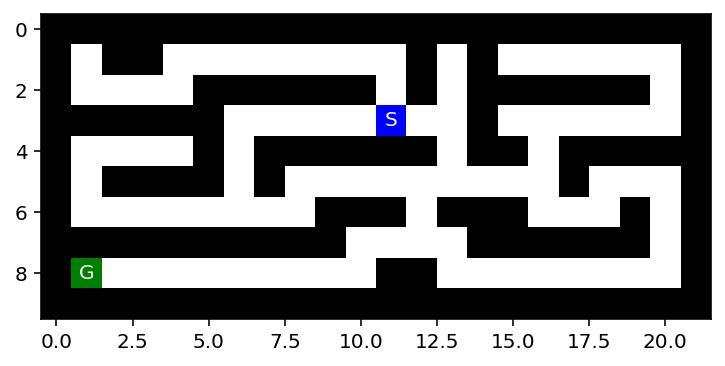

In [348]:
#Small_Maze 
show_maze(maze)

In [349]:
df

,Algorithm,Path Cost,Nodes Expanded
0,BFS,19,90
1,DFS,19,131
2,GBS,29,39
3,A*,19,19


In [350]:
f = open("medium_maze.txt", "r")
maze_str = f.read()
%run maze_helper.py
maze = parse_maze(maze_str)
import pandas as pd
BFS1,BFS2 = BFS(maze)
DFS1,DFS2 = DFS(maze)
GBS1,GBS2 = Greedy_BFS(maze)
A1,A2 = A_Star_alg(maze)

data = [['BFS',BFS1,BFS2],['DFS',DFS1,DFS2],['GBS',GBS1,GBS2],['A*',A1,A1]]
df = pd.DataFrame(data,columns=["Algorithm","Path Cost","Nodes Expanded"])

<Figure size 432x288 with 0 Axes>

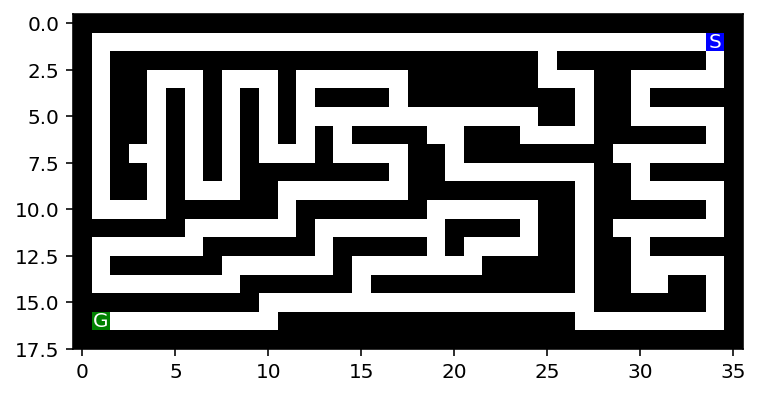

In [351]:
#Medium_Maze
show_maze(maze)

In [352]:
df

,Algorithm,Path Cost,Nodes Expanded
0,BFS,65,283
1,DFS,68,813
2,GBS,89,93
3,A*,55,55


In [360]:
f = open("large_maze.txt", "r")
maze_str = f.read()
%run maze_helper.py
maze = parse_maze(maze_str)
import pandas as pd
BFS1,BFS2 = BFS(maze)
DFS1,DFS2 = DFS(maze)
GBS1,GBS2 = Greedy_BFS(maze)
A1,A2 = A_Star_alg(maze)

data = [['BFS',BFS1,BFS2],['DFS',DFS1,DFS2],['GBS',GBS1,GBS2],['A*',A1,A1]]
df = pd.DataFrame(data,columns=["Algorithm","Path Cost","Nodes Expanded"])

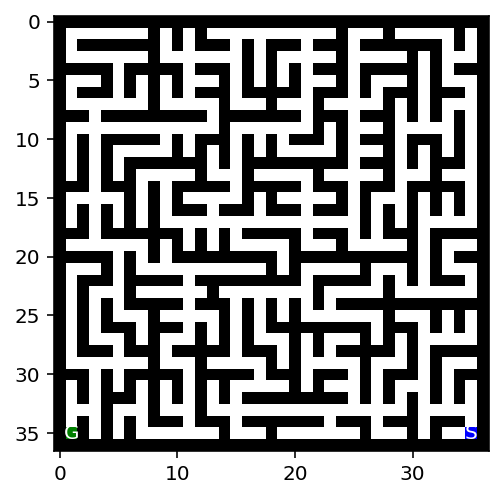

In [361]:
#Large Maze
show_maze(maze)

In [362]:
df

,Algorithm,Path Cost,Nodes Expanded
0,BFS,210,152
1,DFS,210,1159
2,GBS,210,463
3,A*,210,210


In [367]:
f = open("open_maze.txt", "r")
maze_str = f.read()
%run maze_helper.py
maze = parse_maze(maze_str)
import pandas as pd
BFS1,BFS2 = BFS(maze)
DFS1,DFS2 = DFS(maze)
GBS1,GBS2 = Greedy_BFS(maze)
A1,A2 = A_Star_alg(maze)

data = [['BFS',BFS1,BFS2],['DFS',DFS1,DFS2],['GBS',GBS1,GBS2],['A*',A1,A1]]
df = pd.DataFrame(data,columns=["Algorithm","Path Cost","Nodes Expanded"])

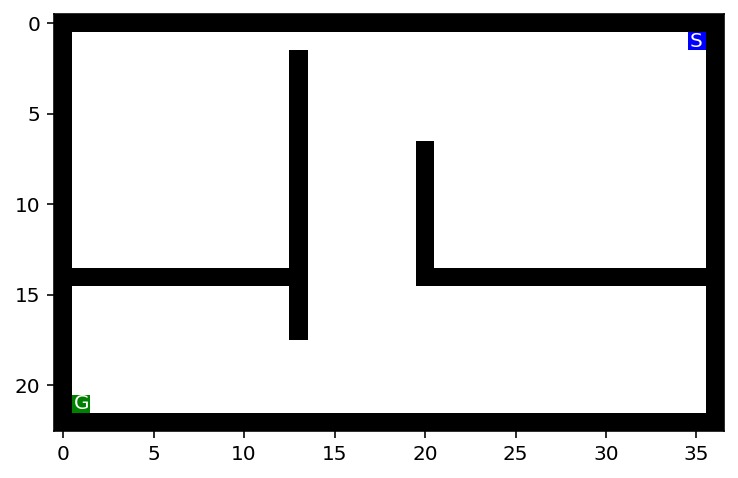

In [368]:
#Open Maze
show_maze(maze)

In [369]:
df

,Algorithm,Path Cost,Nodes Expanded
0,BFS,54,679
1,DFS,54,5
2,GBS,68,91
3,A*,54,54


In [376]:
f = open("loops_maze.txt", "r")
maze_str = f.read()
%run maze_helper.py
maze = parse_maze(maze_str)
import pandas as pd
BFS1,BFS2 = BFS(maze)
DFS1,DFS2 = DFS(maze)
GBS1,GBS2 = Greedy_BFS(maze)
A1,A2 = A_Star_alg(maze)

data = [['BFS',BFS1,BFS2],['DFS',DFS1,DFS2],['GBS',GBS1,GBS2],['A*',A1,A1]]
df = pd.DataFrame(data,columns=["Algorithm","Path Cost","Nodes Expanded"])

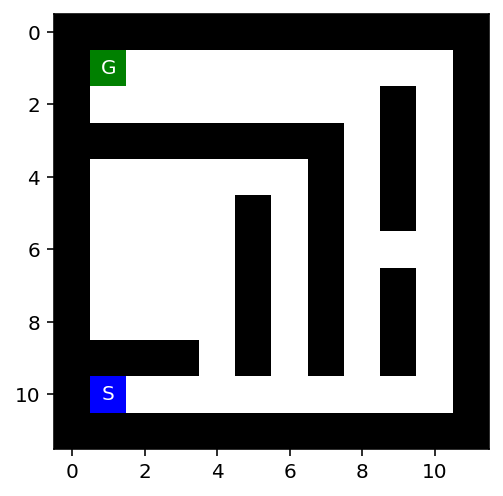

In [377]:
#Loup Maze
show_maze(maze)

In [378]:
df

,Algorithm,Path Cost,Nodes Expanded
0,BFS,23,70
1,DFS,23,2
2,GBS,23,75
3,A*,23,23


In [387]:
f = open("empty_2_maze.txt", "r")
maze_str = f.read()
%run maze_helper.py
maze = parse_maze(maze_str)
import pandas as pd
BFS1,BFS2 = BFS(maze)
DFS1,DFS2 = DFS(maze)
GBS1,GBS2 = Greedy_BFS(maze)
A1,A2 = A_Star_alg(maze)

data = [['BFS',BFS1,BFS2],['DFS',DFS1,DFS2],['GBS',GBS1,GBS2],['A*',A1,A1]]
df = pd.DataFrame(data,columns=["Algorithm","Path Cost","Nodes Expanded"])

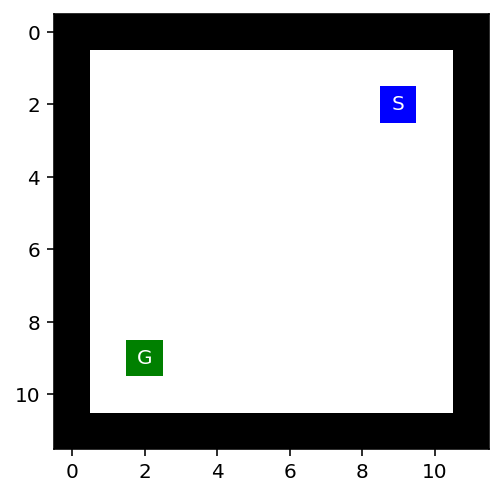

In [388]:
show_maze(maze)

In [389]:
df

,Algorithm,Path Cost,Nodes Expanded
0,BFS,14,92
1,DFS,14,5
2,GBS,14,14
3,A*,14,14


In [396]:
f = open("wall_maze.txt", "r")
maze_str = f.read()
%run maze_helper.py
maze = parse_maze(maze_str)
import pandas as pd
BFS1,BFS2 = BFS(maze)
DFS1,DFS2 = DFS(maze)
GBS1,GBS2 = Greedy_BFS(maze)
A1,A2 = A_Star_alg(maze)

data = [['BFS',BFS1,BFS2],['DFS',DFS1,DFS2],['GBS',GBS1,GBS2],['A*',A1,A1]]
df = pd.DataFrame(data,columns=["Algorithm","Path Cost","Nodes Expanded"])

<Figure size 432x288 with 0 Axes>

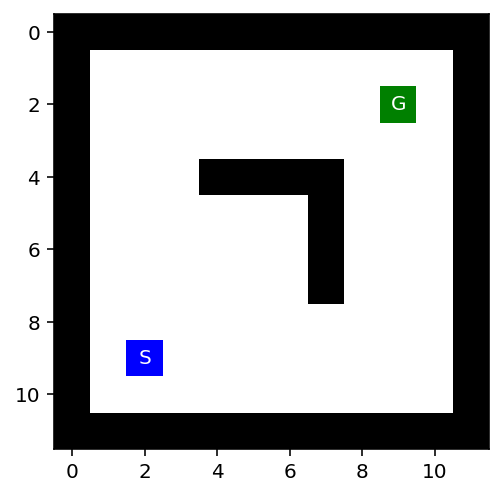

In [397]:
show_maze(maze)

In [398]:
df

,Algorithm,Path Cost,Nodes Expanded
0,BFS,32,78
1,DFS,14,222967
2,GBS,14,14
3,A*,14,14


## Graduate student advanced task: Multiple goals [1 point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+1 Bonus point].

Create a few mazes with multiple goals by adding one or two more goals to the medium size maze.
Solve the maze with your implementations for DFS, BFS, and implement in addition IDS (iterative deepening search using DFS). 

Run experiments to show which implementations find the optimal solution and which do not. Discuss why that is the case.

In [343]:
# Your code/answer goes here

## More advanced tasks to think about

Instead of defining each square as a state, use only intersections as states. Now the storage requirement is reduced, but the path length between two intersections can be different. If we use total path length measured as the number of squares as path cost, how can we make sure that BFS and iterative deepening search is optimal? Change the code to do so.

In [344]:
# Your code/answer goes here

Modify your A* search to add weights (see text book) and explore how different weights influence the result.

In [345]:
# Your code/answer goes here

What happens if the agent does not know the layout of the maze in advance (i.e., faces an unkown, only partially observable environment)? How does the environment look then (PEAS description)? How would you implement a rational agent to solve the maze? What if the agent still has a GPS device to tell the distance to the goal?

In [346]:
# Your code/answer goes here